In [1]:
SEARCH_TERM = "Karnataka"
TWEETS_COUNT = 300
TIME_LIMIT = 120

import keys
import os
import time
import string
import json
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import nltk
import re
import operator 
import math
import re, nltk
import random
import re
import pickle

from IPython.display import HTML, Image, display
from matplotlib import rc
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams 
from collections import defaultdict
from tweepy import Stream
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from matplotlib import animation
#from credentials import *


%matplotlib inline

dir_path = os.getcwd()
dir_path_data = dir_path + "/Data/"


consumer_key = keys.consumer_key
consumer_secret = keys.consumer_secret
access_token = keys.access_token
access_secret = keys.access_secret


print(consumer_key)
print(consumer_secret)
print(access_token)
print(access_secret)


print(dir_path)
print(dir_path_data)

 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)




HImrEBDPQ1v30Ms8yevMAtOc2
hwmtGELZmLXHAaV1Xok9lkUjNjB3n3fu8SMvnGJv1ofnfMKqd0
354844313-ITXlT4314nPV3WxXjEcgq5xlVecRgK2KItdTjkJV
rBvKgdyZaOgcMj5xULpTYZfWaLjlm4wH3qbcUSwJf65tq
/home/karthikeya/ProjectsSJSU/ML_Project
/home/karthikeya/ProjectsSJSU/ML_Project/Data/


In [2]:
# Before running this code
# make a directory named Data and provide the path of the directory at INPUT_DATAPATH
# set SEARCH_TERM as what you would like to search from twitter "ex: apple"
# which would produce the list of tweets for the term "apple" 
# and also store the twitter data into the file stream_apple.json in the directory of INPUT_DATAPATH


class MyListener(StreamListener):
    """Custom StreamListener for streaming data."""

    def __init__(self, data_dir, query, time_limit):
        query_fname = ''.join(convert_valid(one_char) for one_char in query)
        self.start_time = time.time()
        self.limit = TIME_LIMIT
        self.outfile = "%s/stream_%s.json" % (data_dir, query_fname)
        
    def on_data(self, data):
        # removes if a file already exists with same name and creates new file and writes into that
        
        if os.path.exists(self.outfile):
            if os.path.getsize(self.outfile) > 2**20 * 2**10: # 1MB
                os.remove(self.outfile)
        with open(self.outfile,'a+') as f:
            try:
                f.writelines(data.strip("\n"))

                if (time.time() - self.start_time) > self.limit:
                    print('WRITE COMPLETE')
                    time.sleep(1)
                    f.close()
                    return False
                return True

            except BaseException as e:
                print("Error on_data: %s" % str(e))
                time.sleep(5)


    def on_error(self, status):
        print(status)
        return True

    
def convert_valid(one_char):
    """Convert a character into '_' if invalid.
    Arguments:
        one_char -- the char to convert
    Return:
        Character -- converted char
    """
    valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
    if one_char in valid_chars:
        return one_char
    else:
        return '_'
 


In [3]:
twitter_stream = Stream(auth, MyListener(dir_path_data, SEARCH_TERM, TIME_LIMIT)) #calling stream function to stream in live data
twitter_stream.filter(track=[SEARCH_TERM], locations = [15.19, 2.1972,75.42, 50.0040])# filters data based on search term on storing
#languages = ["en"], , locations = [-122.75,36.8, 0,0]

WRITE COMPLETE


In [7]:

com = defaultdict(lambda : defaultdict(int))
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'RT', ':', ',', '’',
                                                   'i\'m', '…', '...', 'a', 'b', 'c'
                                                  'd','g','j','m','p','s','v','y',
                                                  'e','h','k','n','q','t','w','z',
                                                  'f','i','l','o','r','u','x', 'http', 'https',
                                                  'ó','ल','ु','்','ज','I','ब','य','द','ै','ट',
                                                   'भ','ग','प','व','ி','श','amp','ू','।','ध','ு',
                                                   'च','1','ा','ो','ी','कर', 'ो','ह','े','क','म','ी'
                                                  'ि','ं','र','न','ِ','्','ि','ं']    

      
terms = []
tknzr = TweetTokenizer()
num_of_tweets = 0
tweets = []
original_tweets = []
fname = dir_path_data +'/stream_'+SEARCH_TERM+'.json'
with open(fname, 'r') as f:
    count_all = Counter()
    
    for line in f:
        num_of_tweets += 1
        tweet = json.loads(line)
        # Create a list with all the terms
        original = ''
        if 'extended_tweet' in tweet:
            terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
            original = tweet.get('extended_tweet').get('full_text')
            
        elif 'retweeted_status' in tweet:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['retweeted_status']['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet.get('retweeted_status').get('extended_tweet').get('full_text')
            except:
                pass
        else:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet['text']
            except:
                pass
        
#         print(original)
        tweets.append(terms)
        original_tweets.append(original)
        terms_bigram = list(nltk.bigrams(terms))
        
#         print(terms)
#         print(terms_bigram)

        # Build co-occurrence matrix
        for i in range(len(terms)-1):            
            for j in range(i+1, len(terms)):
                w1, w2 = sorted([terms[i], terms[j]])                
                if w1 != w2:
                    com[w1][w2] += 1
    
        # Update the counter
        count_all.update(terms_bigram)
        
# Print the first 10 most frequent words
# print(count_all.most_common(10))


original_tweets = list(filter(None, original_tweets))
# every single tweet vocab put into a list
flat_list = [term for tweet in tweets for term in tweet ]
hashtags_list = [hasht for hasht in flat_list if hasht.startswith('#')]

all_terms_dist = nltk.FreqDist(flat_list)
hash_terms_dist = nltk.FreqDist(hashtags_list)


print(all_terms_dist.most_common(10))

# print(count_all.most_common())


com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:10])

print(num_of_tweets)


'''
Bigrams
A collocation is a sequence of words that occur together unusually often. 
Thus red wine is a collocation, whereas the wine is not. 
A characteristic of collocations is that they are resistant to substitution
with words that have similar senses; for example, maroon wine sounds definitely odd.
'''

[('Karnataka', 320), ('..', 168), ('َ', 164), ('من', 162), ('،', 162), ('😂', 141), ('في', 122), ('ُ', 117), ('prices', 115), ('️', 113)]
[(('َ', 'ُ'), 1304), (('َ', 'ّ'), 1015), (('َ', 'ْ'), 738), (('ل', 'َ'), 707), (('ه', 'َ'), 584), (('ا', 'َ'), 540), (('و', 'َ'), 453), (('ت', 'َ'), 433), (('ي', 'َ'), 425), (('ُ', 'ّ'), 408)]
2111


'\nBigrams\nA collocation is a sequence of words that occur together unusually often. \nThus red wine is a collocation, whereas the wine is not. \nA characteristic of collocations is that they are resistant to substitution\nwith words that have similar senses; for example, maroon wine sounds definitely odd.\n'

In [ ]:

# n_docs is the total n. of tweets
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
 
for term, n in all_terms_dist.most_common():
    p_t[term] = n / num_of_tweets
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / num_of_tweets
        

positive_lex = opinion_lexicon.positive()[:]   
negative_lex = opinion_lexicon.negative()[:]
positive_vocab = [
    'good', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'terrific', ':)', ':-)', 'like', 'love',
    # shall we also include game-specific terms?
    # 'triumph', 'triumphal', 'triumphant', 'victory', etc.
]
positive_vocab += positive_lex
negative_vocab = [
    'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(',
    # 'defeat', etc.
]
negative_vocab += negative_lex

pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
 
print(top_pos)
print(top_neg)

# print(semantic_sorted)



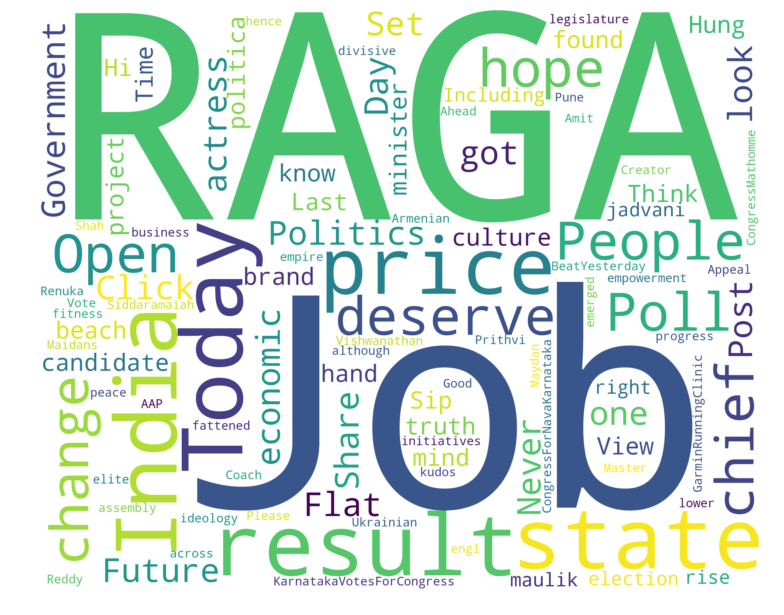

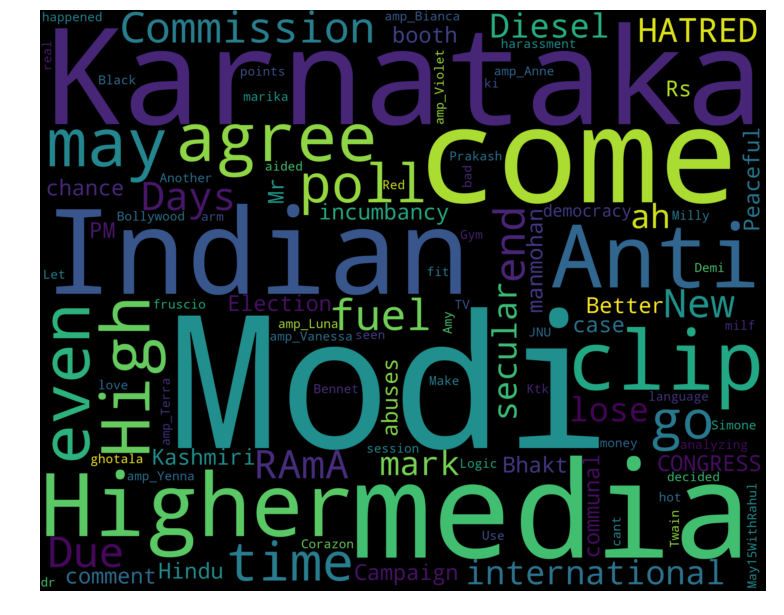

In [7]:

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color,
                      width=2500,
                      height=2000,
                      max_words=100
                     ).generate(words)
#     wordcloud.recolor(color_func = grey_color_func(word = words))
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

pos_term = [terms[0] for terms in semantic_sorted if terms[1] > 0 
            and not terms[0].startswith('@')]

neg_term = [terms[0] for terms in semantic_sorted if terms[1] < 0 
            and not terms[0].startswith('@')]

neutral_term = [terms[0] for terms in semantic_sorted if terms[1] == 0 
            and not terms[0].startswith('@')]

wordcloud_draw(pos_term, 'white')
wordcloud_draw(neg_term)




In [8]:
count = 0
target = []
for tweet in original_tweets:
    score = 0
    pos_counter = 0
    neg_counter = 0
    for word in semantic_sorted:
        if word[0].lower() in tweet.lower() and not word[0].isdigit() and len(word[0]) >= 3:
#             print(word)
            if word[1] > 0:
                pos_counter += 1
            if word[1] < 0:
                neg_counter += 1
        
            score += word[1]
    if(pos_counter > neg_counter or score > 0):
        count += 1
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'
    target.append(sentiment)

In [9]:
print(count)
print(len(original_tweets))
print(len(target))

457
1672
1672


In [6]:
# We create a pandas dataframe as follows:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df = []
df = pd.DataFrame(data=[tweet for tweet in original_tweets], columns=['text'])
df['sentiment']  = np.array([sentiment for sentiment in target])

NameError: name 'original_tweets' is not defined

In [5]:

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'Positive'
#     elif ( analysis.sentiment.polarity == 0):
#         return 'Neutral'
    else:
        return 'Negative'

def analyze_subject(tweet):
    '''
    Utility function to classify the subjectivity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.subjectivity
#     if analysis.sentiment.subjectivity > 0.5:
#         return 'Subjective'
#     else:
#         return 'Not Subjective'



# We create a column with the result of the analysis:
df['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df['text'] ])
df['Subjective'] = np.array([ analyze_subject(tweet) for tweet in df['text'] ])

# We display the updated dataframe with the new column:
#display(df[['text', 'SA', 'Subjective']].head())

pos_tweets_SA = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Positive']
neg_tweets_SA = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Negative']
# neu_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Neutral']

pos_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] == 'Positive']
neg_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] == 'Negative']

print("Percentage of positive tweets SA: {}%".format(len(pos_tweets_SA)*100/len(df['text'])))
print("Percentage de negative tweets SA: {}%".format(len(neg_tweets_SA)*100/len(df['text'])))

print("Percentage of positive tweets Sentiment: {}%".format(len(pos_tweets)*100/len(df['text'])))
print("Percentage de negative tweets Sentiment: {}%".format(len(neg_tweets)*100/len(df['text'])))
# print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text'])))

NameError: name 'df' is not defined

In [106]:
df.head(50)

,text,sentiment,SA,Subjective
0,@kukk44 Madam today karnataka election result but today jodhpur city power sutdown pls start today power,Positive,Negative,0.000000
1,"Ultimately you’ll get what you voted for. So vote for the government that you’ll love even tomorrow, not the government you’re loving temporarily because of small useless gestures. https://t.co/CJqCZlp3LG",Positive,Positive,0.630000
2,"Vote is life of democracy,Vote for development,vote for Karnataka,vote for future.\n@RajveersinghUP @SureshRanaBJP @narendramodi @myogiadityanath @BJP4India @OmMathur_bjp @AmitShah @RSSorg @poonam_mahajan @sunilbansalbjp @Ramlal @nitin_gadkari @shivprakashbjp @naqvimukhtar https://t.co/ftrNOSupjt",Positive,Negative,0.125000
3,"@ManishTewari There isno virtually was she deported or not.stopthis rumour mongering,Karnataka elcection isover.this psuedo secular media and stooges of Gandhifamily willnever stopthis pro muslim comments.Tiwary does not have guts tospeak against Hamid Ansari who is showing hislove for Jinnah.",Negative,Negative,0.000000
4,"Time to think.Can BJP answer this.\nWhy BJP ruled states didn't performed well?\n\nIndia's global poverty rank improves as a result of the performance of five key Southern states - Karnataka, AP, TN, Kerala &amp; Telangana.",Positive,Negative,0.475000
5,"Karnataka election 2018: Will quit to pave way for a Dalit CM if party asks, says CM Siddaramaiah https://t.co/5gZBgoFQ1J",Negative,Negative,0.000000
6,@News18India Sahi bat hai cheafminister sir is a very good but bjp losed to karnataka,Positive,Positive,0.780000
7,"Yogis Campaign in Karnataka was a damp squib,but @ShashiTharoor Storms UP and Steals Hearts in Lucknow, City of Nawabs. https://t.co/xoWpn8Yy8Y",Positive,Negative,0.000000
8,कर्नाटक मे सब चैनल और एक्जिट पोल जब कांग्रेस की वापसी 100% तय है का दावा कर रहे है ऐसे मे अब #EVM माता ने भी कोई भी काला-कांडी करने से मना किया\nअमितशाह : #EVM माता से बोले अब तो आपका ही आसरा है\n#EVM : मैं अब कुछ नही कर सकती करोड़ो लोगो की बददुआ कौन लेगा सत्य मेव जयते\n#Karnataka,Negative,Negative,0.000000
9,"It was a Peaceful Friday in #Aurangabad. Only 100 shops gutted. Petrol bombs hurled. Lives lost. All, due to water cut-off to a mosque for the mounting dues. How insecure can a minority get! But, all the hyperventing anchors are busy rioting over crystal ball gazing in Karnataka.",Negative,Negative,0.610000


In [107]:

wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens if len(l) >= 3]
    filtered_result = list(filter(lambda l: l not in stop, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [108]:
df['normalized_tweet'] = df.text.apply(normalizer)
df[['text','sentiment','normalized_tweet']].head(10)

,text,sentiment,normalized_tweet
0,@kukk44 Madam today karnataka election result but today jodhpur city power sutdown pls start today power,Positive,"[karnataka, election, result, today, jodhpur, city, power, sutdown, pls, start, today, power]"
1,"Ultimately you’ll get what you voted for. So vote for the government that you’ll love even tomorrow, not the government you’re loving temporarily because of small useless gestures. https://t.co/CJqCZlp3LG",Positive,"[get, voted, vote, government, love, even, tomorrow, government, loving, temporarily, small, useless, gesture]"
2,"Vote is life of democracy,Vote for development,vote for Karnataka,vote for future.\n@RajveersinghUP @SureshRanaBJP @narendramodi @myogiadityanath @BJP4India @OmMathur_bjp @AmitShah @RSSorg @poonam_mahajan @sunilbansalbjp @Ramlal @nitin_gadkari @shivprakashbjp @naqvimukhtar https://t.co/ftrNOSupjt",Positive,"[life, democracy, vote, development, vote, karnataka, vote, future, bjp, mahajan, gadkari]"
3,"@ManishTewari There isno virtually was she deported or not.stopthis rumour mongering,Karnataka elcection isover.this psuedo secular media and stooges of Gandhifamily willnever stopthis pro muslim comments.Tiwary does not have guts tospeak against Hamid Ansari who is showing hislove for Jinnah.",Negative,"[virtually, deported, stopthis, rumour, mongering, karnataka, elcection, isover, psuedo, secular, medium, stooge, gandhifamily, willnever, stopthis, pro, muslim, comment, tiwary, gut, tospeak, hamid, ansari, showing, hislove, jinnah]"
4,"Time to think.Can BJP answer this.\nWhy BJP ruled states didn't performed well?\n\nIndia's global poverty rank improves as a result of the performance of five key Southern states - Karnataka, AP, TN, Kerala &amp; Telangana.",Positive,"[think, bjp, answer, bjp, ruled, state, performed, well, india, global, poverty, rank, improves, result, performance, five, key, southern, state, karnataka, kerala, telangana]"
5,"Karnataka election 2018: Will quit to pave way for a Dalit CM if party asks, says CM Siddaramaiah https://t.co/5gZBgoFQ1J",Negative,"[2018, quit, pave, way, dalit, party, asks, say, siddaramaiah]"
6,@News18India Sahi bat hai cheafminister sir is a very good but bjp losed to karnataka,Positive,"[hai, cheafminister, sir, good, bjp, losed, karnataka]"
7,"Yogis Campaign in Karnataka was a damp squib,but @ShashiTharoor Storms UP and Steals Hearts in Lucknow, City of Nawabs. https://t.co/xoWpn8Yy8Y",Positive,"[karnataka, damp, squib, storm, steal, heart, lucknow, city, nawab]"
8,कर्नाटक मे सब चैनल और एक्जिट पोल जब कांग्रेस की वापसी 100% तय है का दावा कर रहे है ऐसे मे अब #EVM माता ने भी कोई भी काला-कांडी करने से मना किया\nअमितशाह : #EVM माता से बोले अब तो आपका ही आसरा है\n#EVM : मैं अब कुछ नही कर सकती करोड़ो लोगो की बददुआ कौन लेगा सत्य मेव जयते\n#Karnataka,Negative,"[evm, evm, karnataka]"
9,"It was a Peaceful Friday in #Aurangabad. Only 100 shops gutted. Petrol bombs hurled. Lives lost. All, due to water cut-off to a mosque for the mounting dues. How insecure can a minority get! But, all the hyperventing anchors are busy rioting over crystal ball gazing in Karnataka.",Negative,"[peaceful, friday, aurangabad, 100, shop, gutted, petrol, bomb, hurled, life, lost, due, water, cut, mosque, mounting, due, insecure, minority, get, hyperventing, anchor, busy, rioting, crystal, ball, gazing, karnataka]"


In [109]:
def load_pickle(file_name):
    with open(file_name + '.pickle', 'rb') as file:
        classifier = pickle.load(file)
    return classifier

In [110]:
classifier = load_pickle('vec_clf')

In [111]:
# classifier.score(data_test, targets_test)
# predicted = classifier.predict(vectorized_data)
print(classifier)
def sentiment2target(sentiment):
    return {
        'Negative': 0,
        'Positive' : 1
    }[sentiment]

# Convert Classification into integer for speed and space efficiency reasons
targets_SA = df.SA.apply(sentiment2target)
targets_sentiment = df.sentiment.apply(sentiment2target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [112]:
predicted = classifier.predict(df.text)
np.mean(predicted == targets_SA)

0.5548902195608783

In [113]:
np.mean(predicted == targets_sentiment)

0.5449101796407185

In [114]:
count_pre = 0
count_pos = 0
for pre in predicted:
    if pre == 1:
        count_pos += 1
        print(df.text[count_pre])
        print("")
    count_pre += 1

Ultimately you’ll get what you voted for. So vote for the government that you’ll love even tomorrow, not the government you’re loving temporarily because of small useless gestures. https://t.co/CJqCZlp3LG

Vote is life of democracy,Vote for development,vote for Karnataka,vote for future.
@RajveersinghUP @SureshRanaBJP @narendramodi @myogiadityanath @BJP4India @OmMathur_bjp @AmitShah @RSSorg @poonam_mahajan @sunilbansalbjp @Ramlal @nitin_gadkari @shivprakashbjp @naqvimukhtar https://t.co/ftrNOSupjt

Karnataka election 2018: Will quit to pave way for a Dalit CM if party asks, says CM Siddaramaiah https://t.co/5gZBgoFQ1J

Karnataka polls: CM Siddaramaiah ‘ready’ to sacrifice post for a Dalit https://t.co/JU7ziFl45V

It's a clear fight in Karnataka. Clean Politics vs Dirty Politics. Mafia vs People. With the BJP fielding the corrupt Reddy gang, we are trying a novel approach to fund our candidate. Support our candidate by making a  contribution.
#CleanPoliticswithINC

https://t.co/D6zkzjxA

In [118]:
print(count_pre) #number of tweets processed using algo
print(count_pos) #number of positive tweets

print


1002
454
